<a href="https://colab.research.google.com/github/danielfrgs/2023_1-Aprendizaje_Maquina/blob/main/notebooks/01_Repaso_Calidad_Datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Librerias

In [ ]:
#Se importan las librerías necesarias
import pandas as pd
import numpy as np
import random
import unicodedata
import re

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import datetime
from datetime import date
import calendar
from IPython.display import HTML
from plotly.offline import plot,iplot
import matplotlib.pyplot as plt
import seaborn as sns
# pd.options.plotting.backend = "plotly"
import plotly.graph_objects as go
import plotly.express as px #graficos express



In [ ]:
#Gráficas

import cufflinks as cf
pd.set_option("display.max_columns",200)
pd.set_option('display.max_rows', 200)
warnings.filterwarnings("ignore")
cf.go_offline()
!pip install sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import chisquare
from scipy import stats
from  functools import reduce
from scipy.stats import ksone
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Funciones

In [ ]:
#Se crea una función para verificar la completitud de las variables de la base.
def completitud(df):
    comple=pd.DataFrame(df.isnull().sum())
    comple.reset_index(inplace=True)
    comple=comple.rename(columns={"index":"columna",0:"total"})
    comple["completitud"]=(1-comple["total"]/df.shape[0])*100
    comple=comple.sort_values(by="completitud",ascending=True)
    comple.reset_index(drop=True,inplace=True)
    return comple

#Se crea una función en la cual se homologuen los simbolos de las variables de texto.
def clean_text(text, pattern="[^a-zA-Z0-9 ]"):
    cleaned_text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern, " ", cleaned_text.decode("ascii"), flags=re.UNICODE)
    cleaned_text = u' '.join(cleaned_text.lower().strip().split())
    return cleaned_text

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
def cross_grafica(df,variable,variable_tgt):
  v_variables_new_by_loan_status = pd.crosstab(df[variable],df[variable_tgt])
  v_variables_new_by_loan_status_index = list(v_variables_new_by_loan_status.index)
  #valores
  malos = list(v_variables_new_by_loan_status.iloc[:,0])  
  buenos = list(v_variables_new_by_loan_status.iloc[:,1])

#Configuraciones de la grafica
  plt.figure(figsize=(16,9))
## Se crean las primeras barras
  plt.bar(v_variables_new_by_loan_status_index, malos, label='0', color = "grey")
  
## Se crean las segundas barras y se apilan sobre las primeras
  plt.bar(v_variables_new_by_loan_status_index, buenos, label='1',  bottom=malos)
  plt.xticks(v_variables_new_by_loan_status_index, v_variables_new_by_loan_status_index) #indice y grupos en este caso es lo mismo (indice el numero de grupos y grupos las etiquetas)
  plt.ylabel("Frecuency")
  plt.xlabel(variable)
  plt.title(variable + '_' + variable_tgt)
  plt.legend()
  # plt.savefig(v_variables_new[i]+".png")
  plt.show()

In [ ]:
def T_E(train, test, columns):
    
    target = list(train.filter(like = 'tgt').columns)[0]
    
    variables_disc = []
    variables_v = []
    variables_c = []

    dic = {}
    iv = []    

    for col in columns:
        if col[0] == 'c':
            variables_c.append(col)
            variables_v.append('v'+col[1:])
            variables_disc.append(col[2:])
        elif col[0] == 'v':
            variables_v.append(col)
            
    for col in variables_c:
        i = 1
        suma = 0
        while i-1 == suma:
            suma = sum(pd.cut(train[col], bins = i).value_counts(1) >= 0.05)
            i += 1  

        train['v' + col[1:]] = pd.cut(train[col], bins = i-1).astype(str)
        
        if col[2:] in variables_disc:
            continue

    # Missings
    for col in variables_v:
        p = pd.DataFrame()
        train[col] = train[col].astype(str).replace({"nan":"Missings"})
        
        # WOE
        aux = train[[col, target]].groupby(col).agg(["count","sum"])
        aux["no_evento"] = aux[target,"count"]-aux[target,"sum"]
        aux["evento"] = aux[target,"sum"]
        aux["evento%"] = aux["evento"]/aux["evento"].sum()
        aux["no_evento%"] = aux["no_evento"]/aux["no_evento"].sum()
        aux["WOE"]=np.log(aux["evento%"]/aux["no_evento%"])
        aux["IV"]=(aux["evento%"]-aux["no_evento%"])*aux["WOE"]
        iv.append(round(aux["IV"].sum(), 5))
        aux = aux[["WOE"]].reset_index().rename(columns={"WOE":"W"+col[1:]})
        train = train.merge(aux,on=col, how="left")
        
        dic[col] = dict(zip(aux[col], aux["W"+col[1:]]))
       
        if col[2:] in variables_disc:
            for i in range(aux[col].shape[0]):
                intervalo = aux.iloc[i,0]
                
                if intervalo == 'Missings':
                    
                    test["W"+col[1:]].replace(to_replace = ['nan'], value = aux.iloc[i,1], inplace = True)
                    
                    
                else:
                    
                    inf = float(intervalo.split(',')[0][1:])
                    sup = float(intervalo.split(',')[1].strip()[0:-1])
                    
                    test[col] = np.where(test['c'+col[1:]].astype(float).between(inf, sup), intervalo, 'Missings')
                    test["W"+col[1:]] = np.where(test['c'+col[1:]].between(inf, sup), aux.iloc[i,1], 'nan')
                            
        else:
            test[col] = test[col].astype(str).replace({"nan":"Missings"})
            test = test.merge(aux,on=col, how="left")
    
    return train, test, dic, pd.DataFrame(zip(variables_v, iv), columns = ['Variables', 'IV'])



In [ ]:
def imput_moda(col):
  X_train[col].value_counts()
  mode=X_train[col].mode()[0]
#Frecuencias observadas
#Valores
  x_i=X_train[col].fillna(mode).value_counts()
  #comprobación con valos crítico de la distribución
  k=x_i.sum()
  p_i=X_train[col].dropna().value_counts(1)
#Frecuencias teóricas esperadas
  m_i=k*p_i
  chi=chisquare(f_obs=x_i,f_exp=m_i)
  p_val=chi.pvalue
  alpha=0.05
  if p_val<alpha:
      print("Rechazamos HO(La porporción de categorias es la misma que la general)")
  else:
      print("Aceptamos HO(La porporción de categorias es la misma que la general)")
  return df[col].replace(np.nan,mode)

def c_imput(col):
   mean=X_train[col].mean()
   median=X_train[col].median()
   mode=X_train[col].mode()[0]   

   originales_mean=list(df[col].dropna().values)
   imputados_mean=list(df[col].fillna(mean).values)
   s_1=stats.ks_2samp(originales_mean,imputados_mean)
   statistic_1=s_1[0]
   pvalue_1=s_1[1]

   originales_median=list(df[col].dropna().values)
   imputados_median=list(df[col].fillna(median).values)
   s_2=stats.ks_2samp(originales_median,imputados_median)
   statistic_2=s_2[0]
   pvalue_2=s_2[1]

   
   originales_mode=list(df[col].dropna().values)
   imputados_mode=list(df[col].fillna(mode).values)
   s_3=stats.ks_2samp(originales_mode,imputados_mode)
   statistic_3=s_3[0]
   pvalue_3=s_3[1]
   
   ## metodo| p-value | estadistico
   # initialize list of lists
   datos = [['mean', pvalue_1,statistic_1], ['median', pvalue_2,statistic_2], ['mode', pvalue_3,statistic_3]]
 
   # Create the pandas DataFrame
   final_tableu = pd.DataFrame(datos, columns = ['Method', 'p-value','statistic'])

   how=final_tableu.iloc[final_tableu['p-value'].idxmax()]['Method']
   imp=SimpleImputer(missing_values=np.nan,strategy=how)
   imp.fit(X_train[[col]])
   X_train[[col]]=imp.transform(X_train[[col]])
   X_test[[col]]=imp.transform(X_test[[col]])


   print(how)
   print(final_tableu)

In [ ]:

#multicolineaidad continuas
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

#Multicolinealidad Categoricas
def multicolinealidad_cate(df,y,threshold=5,only_final_vif=False):
    '''
    Función para calcular el VIF Genralizado, (GVIF, Fox and Monette 1992)
    Las variables no deben de deben de estar transformadas con OneHotEncoder ya que la función lo realiza internamnete.
    Args:
        df
        y
        threshold
        only_final_vif
    
    Returns:
        pandas data frame: a data frame, indexed by factor of the GVIF, GVIF^(1/2Df), VIF^(1/2Df)^2 
    '''

    df_x = df.drop(y,axis=1)
    #Guardamos los nombres de las columnas añadiendo el prefijo

    onehot_list = list(df_x.select_dtypes(include=['category', 'object', 'string']).columns)
    #Generamos las variables dummy 
    
    df_1hot = pd.get_dummies(df_x, drop_first=True, dummy_na=False, prefix_sep='_')


    #Dataframe vacio para guardar los resultados
    gvif_df = pd.DataFrame(columns = ['factor','GVIF','Df','GVIF^(1/2Df)', 'VIF'])

    # Iteramos sobre las columas
    for (columnName, columnData) in df_x.iteritems():
        #Si se generaron las de una columna, es decir la variable tiene más de dos posibilidades utilizamos todas las variables creadas
        
        if columnName in onehot_list:
            X1 = df_1hot.loc[:, df_1hot.columns.str.startswith(columnName)]
            X2 = df_1hot.loc[:, ~df_1hot.columns.str.startswith(columnName)]
        else:
            X1 = df_1hot[[columnName]].values
            X2 = df_1hot.loc[:, df_1hot.columns != columnName].values
        #display(X1)
        # Calculamose gvif
        #A la matriz de correlación de las variables codificadas en caliente del atributo en consideración.
        #B la matriz de correlación de todos los demás atributos del conjunto de datos (uno codificado en dummy y numérico) excluyendo los de A.
        #C la matriz de correlación de las variables consideradas tanto en A como en B.
        #GVIF= (det(A)*det(B))/det(C)
        #display(np.corrcoef(X1, rowvar=False))
        gvif = np.linalg.det(np.array(np.corrcoef(X1, rowvar=False), ndmin=2)) * np.linalg.det(np.corrcoef(X2, rowvar=False)) / np.linalg.det(np.corrcoef(np.append(X1, X2, axis=1), rowvar=False))
        #(GVIF) elevado a (1 / (2 * grados de libertad))
        #Los grados de libertad es 1-n (n=Número de opciones que tiene la variable categorica)
        gvif_12df = np.power(gvif, 1 / (2 * X1.shape[1]))
        gvif_12df_sq = gvif_12df ** 2
        DF =  X1.shape[1]
    

        # 
        new_row = {'factor': columnName, 'GVIF': gvif,'Df':DF, 'GVIF^(1/2Df)': gvif_12df, 'VIF': gvif_12df_sq}
        gvif_df = gvif_df.append(new_row, ignore_index=True)

    gvif_df = gvif_df.set_index('factor')
    if only_final_vif:
        gvif_df_final = gvif_df.drop(['GVIF','Df','GVIF^(1/2Df)'],axis=1)
    else:
        gvif_df_final = gvif_df 
    gvif_filter = gvif_df.loc[gvif_df['VIF'] >= threshold]['VIF'].to_dict()
    if gvif_filter:
        for i in gvif_filter.keys():
            df_x_m = df_x.drop([i],axis=1)
    else:
        df_x_m = df_x
    df_m=pd.concat([df_x_m,df[y]],axis=1)
    return gvif_df_final

#Carga de datos

In [ ]:
#Se carga el archivo

df = pd.read_csv("/content/drive/MyDrive/Diplomado/G11 - Módulo I/Examen/Examen_II/data_examen_2_.csv", encoding="utf-8")
dictio = pd.read_csv("/content/drive/MyDrive/Diplomado/G11 - Módulo I/Examen/Examen_II/ocupaciones_examen2.csv", encoding="utf-8")

# 2.Calidad de los datos

In [ ]:
#Redefino mis valores del tgt:
#Teniamos como bueno al 0 y malo al 1, vamos a invertir estos valores:
df["tgt"] = (df["tgt"]*-1)+1

In [ ]:
df.shape

(51000, 32)

In [ ]:
#Se muestran los primeros 3 registros
df.head(3) 

,ID_CLIENT,ID_SHOP,SEX,MARITAL_STATUS,AGE,QUANT_DEPENDANTS,EDUCATION,FLAG_RESIDENCIAL_PHONE,AREA_CODE_RESIDENCIAL_PHONE,PAYMENT_DAY,SHOP_RANK,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,FLAG_MOTHERS_NAME,FLAG_FATHERS_NAME,FLAG_RESIDENCE_TOWN=WORKING_TOWN,FLAG_RESIDENCE_STATE=WORKING_STATE,MONTHS_IN_THE_JOB,PROFESSION_CODE,MATE_INCOME,FLAG_RESIDENCIAL_ADDRESS=POSTAL_ADDRESS,FLAG_OTHER_CARD,QUANT_BANKING_ACCOUNTS,PERSONAL_REFERENCE_#1,PERSONAL_REFERENCE_#2,FLAG_MOBILE_PHONE,FLAG_CONTACT_PHONE,PERSONAL_NET_INCOME,COD_APPLICATION_BOOTH,QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION,FLAG_CARD_INSURANCE_OPTION,tgt
0,2,15,F,S,18.0,0,NaN,Y,31,20,0,P,216,Y,Y,Y,Y,12,853,0.0,Y,N,0,SARA,FELIPE,N,N,300.0,0,0,N,1
1,4,12,F,C,NaN,0,NaN,N,31,25,0,P,180,Y,Y,N,Y,24,35,0.0,Y,N,0,JACI,VALERIA ALEXANDRA TRAJANO,N,N,304.0,0,0,N,1
2,5,16,F,S,28.0,0,NaN,Y,31,25,0,,12,Y,Y,Y,Y,12,24,0.0,Y,N,0,NaN,SANDRO L P MARTINS,N,N,250.0,0,0,N,1


In [ ]:
#Se validan los tipos de variables de la base
df.dtypes

ID_CLIENT                                      int64
ID_SHOP                                        int64
SEX                                           object
MARITAL_STATUS                                object
AGE                                          float64
QUANT_DEPENDANTS                               int64
EDUCATION                                    float64
FLAG_RESIDENCIAL_PHONE                        object
AREA_CODE_RESIDENCIAL_PHONE                    int64
PAYMENT_DAY                                    int64
SHOP_RANK                                      int64
RESIDENCE_TYPE                                object
MONTHS_IN_RESIDENCE                            int64
FLAG_MOTHERS_NAME                             object
FLAG_FATHERS_NAME                             object
FLAG_RESIDENCE_TOWN=WORKING_TOWN              object
FLAG_RESIDENCE_STATE=WORKING_STATE            object
MONTHS_IN_THE_JOB                              int64
PROFESSION_CODE                               

## Completitud

In [ ]:
#Primero, se revisa la completitud de la Base antes de re-etiquetar las variables para así trabajar con menos datos, 
#donde solo ocuparemos las que cumplan con el 80% de la misma.
completitud(df)

,columna,total,completitud
0,EDUCATION,51000,0.000000
1,PERSONAL_REFERENCE_#1,20625,59.558824
2,PERSONAL_REFERENCE_#2,13887,72.770588
3,AGE,2472,95.152941
4,FLAG_CONTACT_PHONE,1279,97.492157
5,MATE_INCOME,306,99.400000
6,SEX,3,99.994118
7,ID_CLIENT,0,100.000000
8,FLAG_RESIDENCIAL_ADDRESS=POSTAL_ADDRESS,0,100.000000
9,FLAG_OTHER_CARD,0,100.000000


In [ ]:
# Se eliminan las que tengan menos del 80 % de registros 
complet = completitud(df)
complet.index = complet.loc[:,"columna"]
complet = complet.loc[:,"completitud"]
complet = complet[(complet.iloc[:]>80)] == True
df = df.loc[:,list(complet.index)]

In [ ]:
completitud(df) #Revisamos nuevamente su completitud

,columna,total,completitud
0,AGE,2472,95.152941
1,FLAG_CONTACT_PHONE,1279,97.492157
2,MATE_INCOME,306,99.400000
3,SEX,3,99.994118
4,ID_SHOP,0,100.000000
5,MARITAL_STATUS,0,100.000000
6,QUANT_DEPENDANTS,0,100.000000
7,FLAG_RESIDENCIAL_PHONE,0,100.000000
8,AREA_CODE_RESIDENCIAL_PHONE,0,100.000000
9,PAYMENT_DAY,0,100.000000


## Etiquetado de variable

In [ ]:
#Segundo, se cambian los nombres de las variables

#Prefijos para los tipos de variables
#La siguiente nomenclatura se trabajara en el módulo
# "c_"  - Variables numericas : Discretas y continuas
# "v_"  - Variables categoricas
# "d_"  - Variables tipo fecha
# "t_"  - Variables de texto : comentarios, descripciones, url

c_variables=["AGE", "MATE_INCOME", "MONTHS_IN_RESIDENCE", "MONTHS_IN_THE_JOB", "PERSONAL_NET_INCOME"]
v_variables=["FLAG_CONTACT_PHONE", "SEX", "ID_SHOP", "MARITAL_STATUS", "QUANT_DEPENDANTS", "FLAG_RESIDENCIAL_PHONE", "AREA_CODE_RESIDENCIAL_PHONE", "PAYMENT_DAY", "SHOP_RANK",
             "RESIDENCE_TYPE", "FLAG_MOTHERS_NAME", "FLAG_FATHERS_NAME", "FLAG_RESIDENCE_TOWN=WORKING_TOWN", "FLAG_RESIDENCE_STATE=WORKING_STATE", "PROFESSION_CODE",
             "QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION", "COD_APPLICATION_BOOTH", "FLAG_MOBILE_PHONE", "QUANT_BANKING_ACCOUNTS", "FLAG_OTHER_CARD", "FLAG_RESIDENCIAL_ADDRESS=POSTAL_ADDRESS",
             "ID_CLIENT", "FLAG_CARD_INSURANCE_OPTION"]

# d_variables=["issue_d", "earliest_cr_line"]
# t_variables=["address"]

#Renombramos las variables agregandole su sufijo
c_variables_new=["c_"+x for x in c_variables]
v_variables_new=["v_"+x for x in v_variables]
# d_variables_new=["d_"+x for x in d_variables]
# t_variables_new=["t_"+x for x in t_variables]
df.rename(columns=dict(zip(v_variables,v_variables_new)),inplace=True)
df.rename(columns=dict(zip(c_variables,c_variables_new)),inplace=True)
# df.rename(columns=dict(zip(d_variables,d_variables_new)),inplace=True)
# df.rename(columns=dict(zip(t_variables,t_variables_new)),inplace=True)

In [ ]:
df.isna().sum()

c_AGE                                          2472
v_FLAG_CONTACT_PHONE                           1279
c_MATE_INCOME                                   306
v_SEX                                             3
v_ID_CLIENT                                       0
v_FLAG_RESIDENCIAL_ADDRESS=POSTAL_ADDRESS         0
v_FLAG_OTHER_CARD                                 0
v_QUANT_BANKING_ACCOUNTS                          0
v_FLAG_MOBILE_PHONE                               0
c_PERSONAL_NET_INCOME                             0
v_COD_APPLICATION_BOOTH                           0
v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION       0
v_PROFESSION_CODE                                 0
c_MONTHS_IN_THE_JOB                               0
v_FLAG_RESIDENCE_TOWN=WORKING_TOWN                0
v_FLAG_CARD_INSURANCE_OPTION                      0
v_FLAG_FATHERS_NAME                               0
v_FLAG_MOTHERS_NAME                               0
c_MONTHS_IN_RESIDENCE                             0
v_RESIDENCE_

## Limpieza

In [ ]:
#limpiamos las variables categoricas

for i in v_variables_new:
  df[i] = df[i].map(lambda x:clean_text(str(x).lower()).replace("\n",""))

In [ ]:
#Vemos los datos numericos y si son consistentes
df.describe(percentiles=np.arange(0.1,1.1,.1))

,c_AGE,c_MATE_INCOME,c_MONTHS_IN_THE_JOB,c_MONTHS_IN_RESIDENCE,tgt
count,48528.000000,50694.000000,51000.000000,51000.000000,51000.000000
mean,35.321814,55.385294,50.629412,153.104471,0.722098
std,14.596345,913.591103,73.918715,136.435592,0.447969
min,15.000000,0.000000,0.000000,0.000000,0.000000
10%,20.000000,0.000000,0.000000,12.000000,0.000000
20%,22.000000,0.000000,0.000000,24.000000,0.000000
30%,25.000000,0.000000,12.000000,48.000000,1.000000
40%,29.000000,0.000000,12.000000,72.000000,1.000000
50%,33.000000,0.000000,24.000000,120.000000,1.000000
60%,37.000000,0.000000,36.000000,168.000000,1.000000


In [ ]:
#observemos que esta totalmente en 0's

df = df.drop(columns="c_MATE_INCOME")

#Removemos las variables que quitamos anteriormente
c_variables_new.remove("c_MATE_INCOME")

In [ ]:
#Vemos si alguna variable tiene solo un valor

for i in range(0, len(v_variables_new)):
  print(v_variables_new[i])
  print(df[v_variables_new[i]].value_counts(1), "\n")

v_FLAG_CONTACT_PHONE
n      0.974922
nan    0.025078
Name: v_FLAG_CONTACT_PHONE, dtype: float64 

v_SEX
f      0.685255
m      0.299176
n a    0.015510
nan    0.000059
Name: v_SEX, dtype: float64 

v_ID_SHOP
25    0.133118
22    0.098137
24    0.088137
55    0.085078
23    0.059686
20    0.045020
1     0.040059
12    0.039725
15    0.038235
19    0.033961
3     0.033961
10    0.032765
16    0.030471
9     0.025706
21    0.025451
17    0.023824
11    0.023804
7     0.017000
18    0.016255
2     0.015255
13    0.014922
6     0.014431
4     0.013137
14    0.012784
5     0.012588
8     0.012196
66    0.009333
96    0.004667
50    0.000157
81    0.000118
77    0.000020
Name: v_ID_SHOP, dtype: float64 

v_MARITAL_STATUS
s    0.508059
c    0.344490
o    0.055725
v    0.048471
d    0.043255
Name: v_MARITAL_STATUS, dtype: float64 

v_QUANT_DEPENDANTS
0    1.0
Name: v_QUANT_DEPENDANTS, dtype: float64 

v_FLAG_RESIDENCIAL_PHONE
y    0.815843
n    0.184157
Name: v_FLAG_RESIDENCIAL_PHONE, dtype: fl

In [ ]:
#Eliminamos las que sólo tienen 1 valor
df = df.drop(columns=["v_QUANT_DEPENDANTS", "v_COD_APPLICATION_BOOTH", "v_FLAG_MOBILE_PHONE", "v_QUANT_BANKING_ACCOUNTS", "v_FLAG_OTHER_CARD", "v_FLAG_CARD_INSURANCE_OPTION",
                      "v_SHOP_RANK", "v_FLAG_MOTHERS_NAME", "v_FLAG_FATHERS_NAME", "v_FLAG_RESIDENCE_STATE=WORKING_STATE", "v_FLAG_RESIDENCIAL_ADDRESS=POSTAL_ADDRESS", "v_FLAG_CONTACT_PHONE"])

#Removemos las variables que quitamos anteriormente
#Tener cuidado, puesto que solo se puede correr este una vez o reiniciamos
v_variables_new.remove("v_QUANT_DEPENDANTS")
v_variables_new.remove("v_COD_APPLICATION_BOOTH")
v_variables_new.remove("v_FLAG_MOBILE_PHONE")
v_variables_new.remove("v_QUANT_BANKING_ACCOUNTS")
v_variables_new.remove("v_FLAG_OTHER_CARD")
v_variables_new.remove("v_FLAG_CARD_INSURANCE_OPTION")
v_variables_new.remove("v_FLAG_CONTACT_PHONE")
v_variables_new.remove("v_SHOP_RANK")
v_variables_new.remove("v_FLAG_MOTHERS_NAME")
v_variables_new.remove("v_FLAG_FATHERS_NAME")
v_variables_new.remove("v_FLAG_RESIDENCE_STATE=WORKING_STATE")
v_variables_new.remove("v_FLAG_RESIDENCIAL_ADDRESS=POSTAL_ADDRESS")

In [ ]:
#Comprobamos nuestros valores

for i in range(0, len(v_variables_new)):
  print(v_variables_new[i])
  print(df[v_variables_new[i]].value_counts(1), "\n")

v_SEX
f      0.685255
m      0.299176
n a    0.015510
nan    0.000059
Name: v_SEX, dtype: float64 

v_ID_SHOP
25    0.133118
22    0.098137
24    0.088137
55    0.085078
23    0.059686
20    0.045020
1     0.040059
12    0.039725
15    0.038235
19    0.033961
3     0.033961
10    0.032765
16    0.030471
9     0.025706
21    0.025451
17    0.023824
11    0.023804
7     0.017000
18    0.016255
2     0.015255
13    0.014922
6     0.014431
4     0.013137
14    0.012784
5     0.012588
8     0.012196
66    0.009333
96    0.004667
50    0.000157
81    0.000118
77    0.000020
Name: v_ID_SHOP, dtype: float64 

v_MARITAL_STATUS
s    0.508059
c    0.344490
o    0.055725
v    0.048471
d    0.043255
Name: v_MARITAL_STATUS, dtype: float64 

v_FLAG_RESIDENCIAL_PHONE
y    0.815843
n    0.184157
Name: v_FLAG_RESIDENCIAL_PHONE, dtype: float64 

v_AREA_CODE_RESIDENCIAL_PHONE
31    0.700980
50    0.221843
5     0.049647
23    0.020059
24    0.002373
49    0.000961
32    0.000647
27    0.000529
42    0.000

In [ ]:
#Comprobamos que vuelvan los nan's para así en el apartado de missings llenaremos
print(df.isna().sum())

c_AGE                                          2472
v_SEX                                             0
v_ID_CLIENT                                       0
c_PERSONAL_NET_INCOME                             0
v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION       0
v_PROFESSION_CODE                                 0
c_MONTHS_IN_THE_JOB                               0
v_FLAG_RESIDENCE_TOWN=WORKING_TOWN                0
c_MONTHS_IN_RESIDENCE                             0
v_RESIDENCE_TYPE                                  0
v_PAYMENT_DAY                                     0
v_AREA_CODE_RESIDENCIAL_PHONE                     0
v_FLAG_RESIDENCIAL_PHONE                          0
v_MARITAL_STATUS                                  0
v_ID_SHOP                                         0
tgt                                               0
dtype: int64


## Consistencia

In [ ]:

columnasv = list(df.filter(like ="v_").columns)

#Buscamos todos los valores que tengan las columnas y sean vacios
for i in range(0, len(columnasv)):
  print(columnasv[i])
  print(df[df[columnasv[i]] == "nan"].shape[0])
  print(df[df[columnasv[i]] == ""].shape[0])
  print(df[df[columnasv[i]] == "n a"].shape[0])

#Notemos que tenemos inconsistencias.

v_SEX
3
0
791
v_ID_CLIENT
0
0
0
v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION
0
0
0
v_PROFESSION_CODE
0
0
0
v_FLAG_RESIDENCE_TOWN=WORKING_TOWN
0
0
0
v_RESIDENCE_TYPE
0
7476
0
v_PAYMENT_DAY
0
0
0
v_AREA_CODE_RESIDENCIAL_PHONE
0
0
0
v_FLAG_RESIDENCIAL_PHONE
0
0
0
v_MARITAL_STATUS
0
0
0
v_ID_SHOP
0
0
0


In [ ]:
#imputamos los valores incosistentes a NaN
columans=list(df.columns)
for i in range(0, len(columans)):
  df[columans[i]] = df[columans[i]].replace(["nan", "n a", " ", "",'n.a.'], np.nan)

In [ ]:
completitud(df) #Revisamos nuevamente su completitud

,columna,total,completitud
0,v_RESIDENCE_TYPE,7476,85.341176
1,c_AGE,2472,95.152941
2,v_SEX,794,98.443137
3,c_PERSONAL_NET_INCOME,198,99.611765
4,v_ID_CLIENT,0,100.000000
5,v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION,0,100.000000
6,v_PROFESSION_CODE,0,100.000000
7,c_MONTHS_IN_THE_JOB,0,100.000000
8,v_FLAG_RESIDENCE_TOWN=WORKING_TOWN,0,100.000000
9,c_MONTHS_IN_RESIDENCE,0,100.000000


In [ ]:
df[df['c_AGE']>99].head(3) #Observamos estas inconsistencias y las eliminamos
df["c_AGE"] = np.where(df["c_AGE"]>99, np.nan, df["c_AGE"])

In [ ]:
df[df['c_MONTHS_IN_THE_JOB']>840] #Observamos estas inconsistencias y las eliminamos
df['c_MONTHS_IN_THE_JOB'] = np.where(df['c_MONTHS_IN_THE_JOB']>840, np.nan, df['c_MONTHS_IN_THE_JOB'])

In [ ]:
df[df['c_MONTHS_IN_RESIDENCE']>1190] #Observamos estas inconsistencias y las eliminamos
df['c_MONTHS_IN_RESIDENCE'] = np.where(df['c_MONTHS_IN_RESIDENCE']>1190, np.nan, df['c_MONTHS_IN_RESIDENCE'])

In [ ]:
completitud(df) #Revisamos su completitud nuevamente

,columna,total,completitud
0,v_RESIDENCE_TYPE,7476,85.341176
1,c_AGE,2501,95.096078
2,v_SEX,794,98.443137
3,c_PERSONAL_NET_INCOME,198,99.611765
4,c_MONTHS_IN_THE_JOB,3,99.994118
5,v_ID_CLIENT,0,100.000000
6,v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION,0,100.000000
7,v_PROFESSION_CODE,0,100.000000
8,v_FLAG_RESIDENCE_TOWN=WORKING_TOWN,0,100.000000
9,c_MONTHS_IN_RESIDENCE,0,100.000000


In [ ]:
#Vemos las variables numericas
df.filter(like="c_").dtypes

c_AGE                    float64
c_PERSONAL_NET_INCOME     object
c_MONTHS_IN_THE_JOB      float64
c_MONTHS_IN_RESIDENCE    float64
dtype: object

In [ ]:
# Modificamos la variable
df['c_PERSONAL_NET_INCOME']=df['c_PERSONAL_NET_INCOME'].astype('float')

In [ ]:
df.filter(like='v_').dtypes #Notamos que todo esta en orden

v_SEX                                          object
v_ID_CLIENT                                    object
v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION    object
v_PROFESSION_CODE                              object
v_FLAG_RESIDENCE_TOWN=WORKING_TOWN             object
v_RESIDENCE_TYPE                               object
v_PAYMENT_DAY                                  object
v_AREA_CODE_RESIDENCIAL_PHONE                  object
v_FLAG_RESIDENCIAL_PHONE                       object
v_MARITAL_STATUS                               object
v_ID_SHOP                                      object
dtype: object

##Duplicados

In [ ]:
#Vemos el numero de duplicado que tenemos

print(df[df.duplicated()].shape[0])
print(df[df[["v_ID_CLIENT"]].duplicated()].shape[0])

7
1000


In [ ]:
#Continuamos con el borrado anterior y resetamos el indice
#Eliminamos duplicados de la tabla
df = df.drop(df[df.duplicated()].index, axis = 0, inplace=False)
df = df.drop(df[df[["v_ID_CLIENT"]].duplicated()].index, axis = 0, inplace=False)
df.reset_index(drop=True,inplace=True)
df.shape #Vemos el nuevo tamaño de la base

(50000, 16)

## Normalización

In [ ]:
#Veamos los datos que tenemos en el data frame y todos sus valores unicos para saber si es apto para aplicar una normalizacion o tener que borrar 

for i in range(0, len(v_variables_new)):
  print(v_variables_new[i])
  print(df[v_variables_new[i]].nunique())

v_SEX
2
v_ID_SHOP
31
v_MARITAL_STATUS
5
v_FLAG_RESIDENCIAL_PHONE
2
v_AREA_CODE_RESIDENCIAL_PHONE
67
v_PAYMENT_DAY
16
v_RESIDENCE_TYPE
4
v_FLAG_RESIDENCE_TOWN=WORKING_TOWN
2
v_PROFESSION_CODE
295
v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION
4
v_ID_CLIENT
50000


In [ ]:
df["v_AREA_CODE_RESIDENCIAL_PHONE"].value_counts(1)

31    0.70096
50    0.22200
5     0.04950
23    0.02000
24    0.00240
49    0.00096
32    0.00066
27    0.00054
42    0.00028
52    0.00024
38    0.00024
56    0.00020
11    0.00014
68    0.00014
33    0.00012
43    0.00010
26    0.00008
41    0.00006
8     0.00006
48    0.00006
1     0.00006
2     0.00006
34    0.00006
7     0.00006
57    0.00004
67    0.00004
9     0.00004
69    0.00004
37    0.00004
12    0.00004
6     0.00004
62    0.00004
22    0.00002
4     0.00002
64    0.00002
51    0.00002
63    0.00002
47    0.00002
70    0.00002
65    0.00002
29    0.00002
60    0.00002
18    0.00002
54    0.00002
53    0.00002
61    0.00002
58    0.00002
20    0.00002
21    0.00002
15    0.00002
59    0.00002
45    0.00002
39    0.00002
14    0.00002
36    0.00002
35    0.00002
17    0.00002
25    0.00002
10    0.00002
46    0.00002
3     0.00002
40    0.00002
19    0.00002
44    0.00002
30    0.00002
13    0.00002
28    0.00002
Name: v_AREA_CODE_RESIDENCIAL_PHONE, dtype: float64

In [ ]:
#Normalizamos los valores ya que la mayoria de la información esta en 2

valores_code_residencial = list(df["v_AREA_CODE_RESIDENCIAL_PHONE"].value_counts().index)
df["v_AREA_CODE_RESIDENCIAL_PHONE"] = df["v_AREA_CODE_RESIDENCIAL_PHONE"].replace(valores_code_residencial[2:], "other")
df["v_AREA_CODE_RESIDENCIAL_PHONE"].value_counts(1)

31       0.70096
50       0.22200
other    0.07704
Name: v_AREA_CODE_RESIDENCIAL_PHONE, dtype: float64

In [ ]:
print(df["v_SEX"].value_counts(1))

f    0.69587
m    0.30413
Name: v_SEX, dtype: float64


In [ ]:
print(df["v_RESIDENCE_TYPE"].value_counts(1))

p    0.742734
a    0.128375
c    0.087527
o    0.041365
Name: v_RESIDENCE_TYPE, dtype: float64


In [ ]:
print(df["v_MARITAL_STATUS"].value_counts())

s    25422
c    17194
o     2788
v     2442
d     2154
Name: v_MARITAL_STATUS, dtype: int64


In [ ]:
print(df["v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION"].value_counts()) #podemos generar solo 0 y 1's identificando si tiene una o más tarjetas
df["v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION"] = df["v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION"].replace(["2","3"], "1")

0    43431
1     5684
2      881
3        4
Name: v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION, dtype: int64


In [ ]:
dictio.PROFESSION_CODE=dictio.PROFESSION_CODE.astype('str') #Lo pasamos a string el diccionario de profesiones

In [ ]:
dictio.dtypes #revisamos que se haya modificado

PROFESSION_CODE    object
PROFESSION         object
dtype: object

In [ ]:
#Cruzando con ocupaciones
df=pd.merge(df, dictio, how='left', right_on='PROFESSION_CODE', left_on='v_PROFESSION_CODE') #Hacemos el cruce de tablas para tener la profesion por nombre

In [ ]:
#Eliminamos la columna del codigo y renombramos la misma

df = df.drop(columns="PROFESSION_CODE")
df = df.drop(columns="v_PROFESSION_CODE")
df.rename(columns={'PROFESSION':'v_PROFESSION'}, inplace=True)
v_variables_new.remove("v_PROFESSION_CODE")

In [ ]:
df.head(3) #Vemos que se hayan modificado correctamente los datos

,c_AGE,v_SEX,v_ID_CLIENT,c_PERSONAL_NET_INCOME,v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION,c_MONTHS_IN_THE_JOB,v_FLAG_RESIDENCE_TOWN=WORKING_TOWN,c_MONTHS_IN_RESIDENCE,v_RESIDENCE_TYPE,v_PAYMENT_DAY,v_AREA_CODE_RESIDENCIAL_PHONE,v_FLAG_RESIDENCIAL_PHONE,v_MARITAL_STATUS,v_ID_SHOP,tgt,v_PROFESSION
0,18.0,f,2,300.0,0,12.0,y,216.0,p,20,31,y,s,15,1,Educational Instruction and Library
1,NaN,f,4,304.0,0,24.0,n,180.0,p,25,31,n,c,12,1,"Life, Physical, and Social Science"
2,28.0,f,5,250.0,0,12.0,y,12.0,NaN,25,31,y,s,16,1,Healthcare Practitioners and Technical


## Análisis exploratorio

In [ ]:
df.dtypes #observamos que todo este en orden con nuestros datos

c_AGE                                          float64
v_SEX                                           object
v_ID_CLIENT                                     object
c_PERSONAL_NET_INCOME                          float64
v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION     object
c_MONTHS_IN_THE_JOB                            float64
v_FLAG_RESIDENCE_TOWN=WORKING_TOWN              object
c_MONTHS_IN_RESIDENCE                          float64
v_RESIDENCE_TYPE                                object
v_PAYMENT_DAY                                   object
v_AREA_CODE_RESIDENCIAL_PHONE                   object
v_FLAG_RESIDENCIAL_PHONE                        object
v_MARITAL_STATUS                                object
v_ID_SHOP                                       object
tgt                                              int64
v_PROFESSION                                    object
dtype: object

In [ ]:
v_variables_new

['v_SEX',
 'v_ID_SHOP',
 'v_MARITAL_STATUS',
 'v_FLAG_RESIDENCIAL_PHONE',
 'v_AREA_CODE_RESIDENCIAL_PHONE',
 'v_PAYMENT_DAY',
 'v_RESIDENCE_TYPE',
 'v_FLAG_RESIDENCE_TOWN=WORKING_TOWN',
 'v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION',
 'v_ID_CLIENT']

## Gráficas

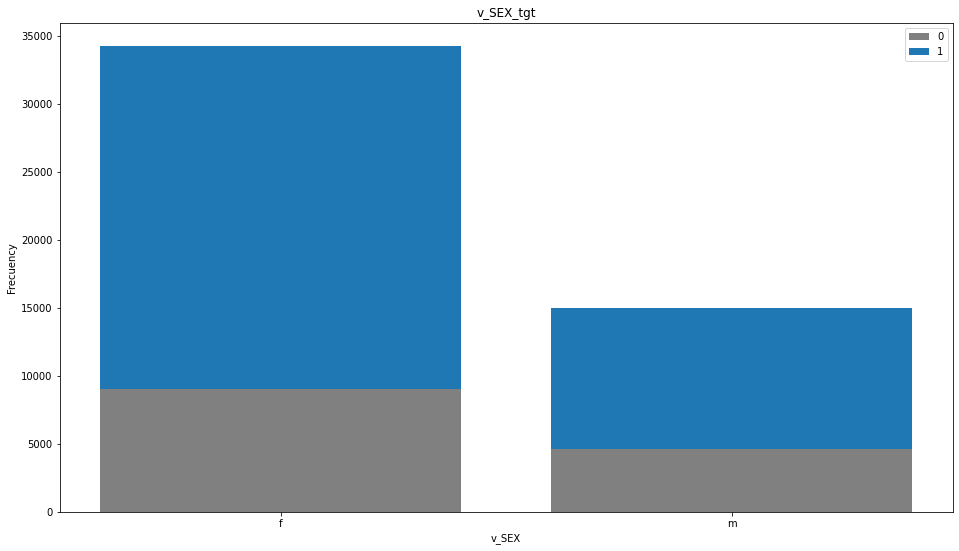

In [ ]:
cross_grafica(df,"v_SEX", "tgt")

#Observemos que tenemos el doble aproximadamente de muejeres que de hombres teniendo tambien porporción de rechazados similar entre ellos

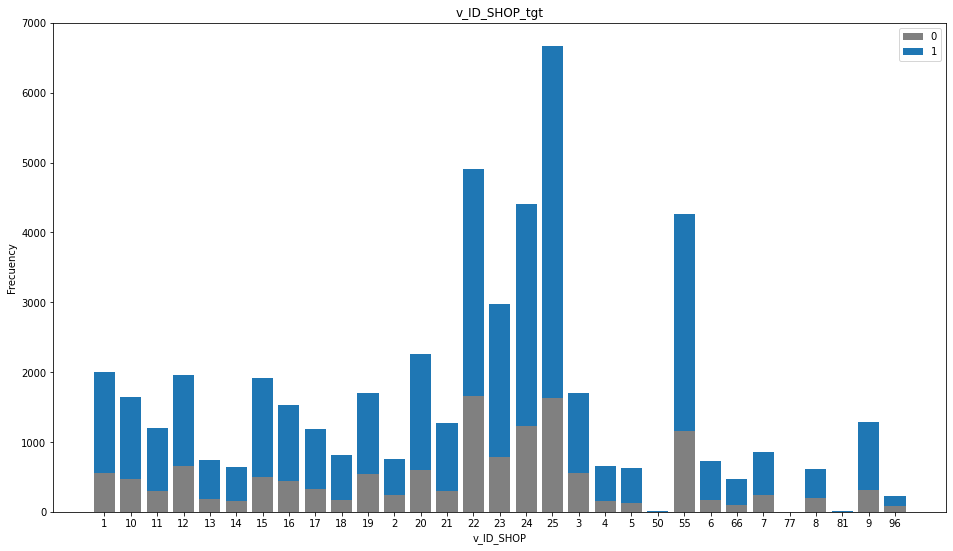

In [ ]:
cross_grafica(df,"v_ID_SHOP", "tgt")

#Notemos que la tienda con más solicitudes es la 25, seguido de la 22, 24, 55 y 23. Estas abarcan 
# el 40% de nuestro total, el que más tiene probabilidad de incumplimiento la tienda 22.

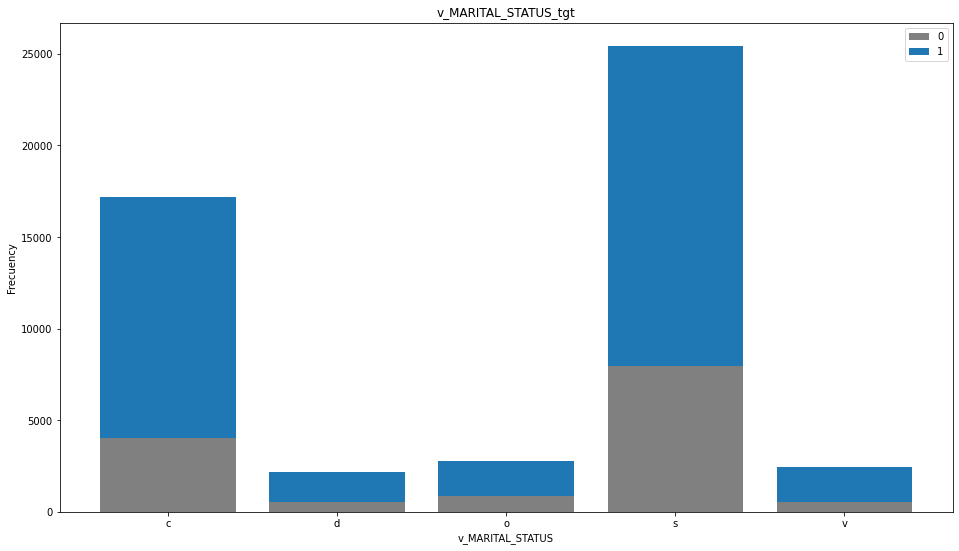

In [ ]:
cross_grafica(df,"v_MARITAL_STATUS", "tgt")

#Observemos que 2 de nuestros valores son los más importantes, abarcando el 85% de nuestros datos

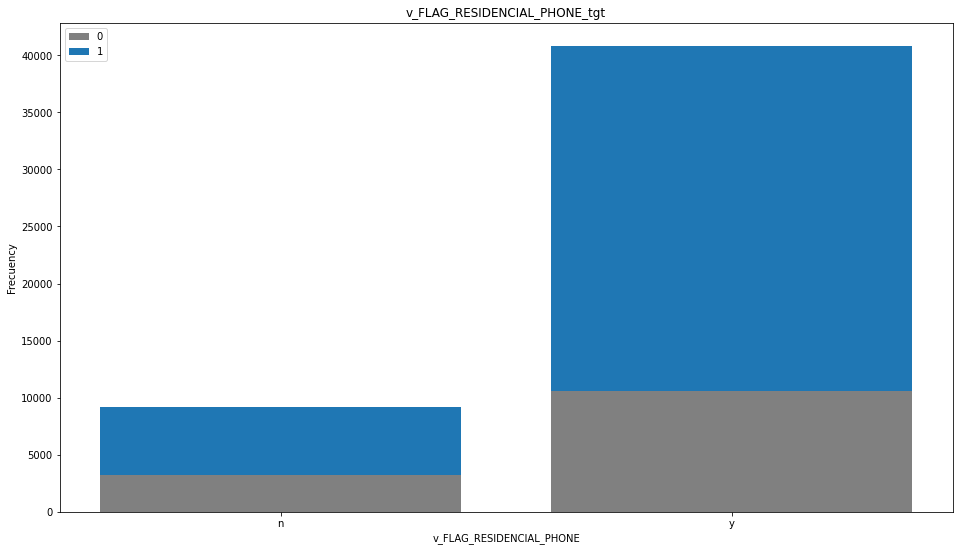

In [ ]:
cross_grafica(df,"v_FLAG_RESIDENCIAL_PHONE", "tgt")

#Vemos que tenemos 4 veces más las personas que tienen telefono que los que no, con una probabilidad de incumplimiento menor para los que tienen

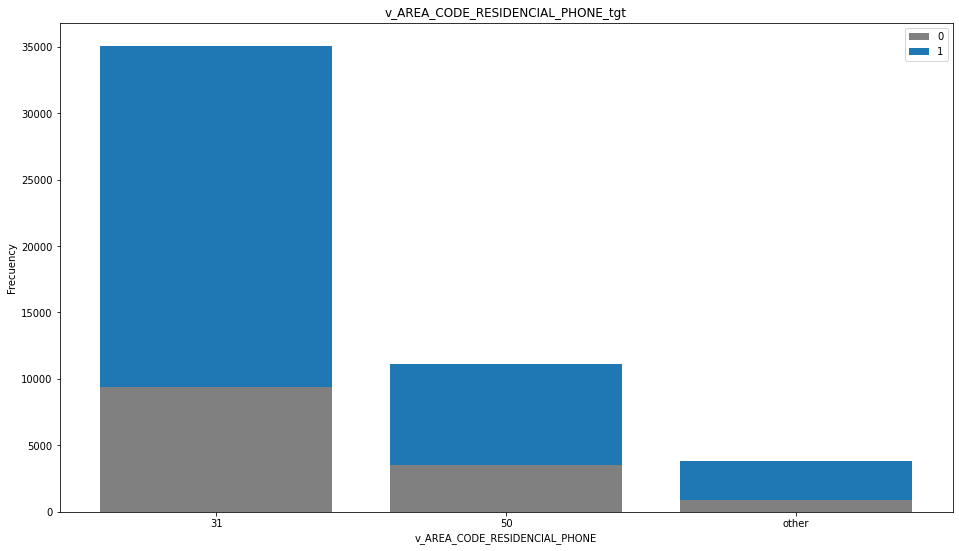

In [ ]:
cross_grafica(df,"v_AREA_CODE_RESIDENCIAL_PHONE", "tgt")

# Tenemos un 70% de nuestros solicitantes con codigo 31, un 20% en el codigo 50 y el 10% en otros codigos

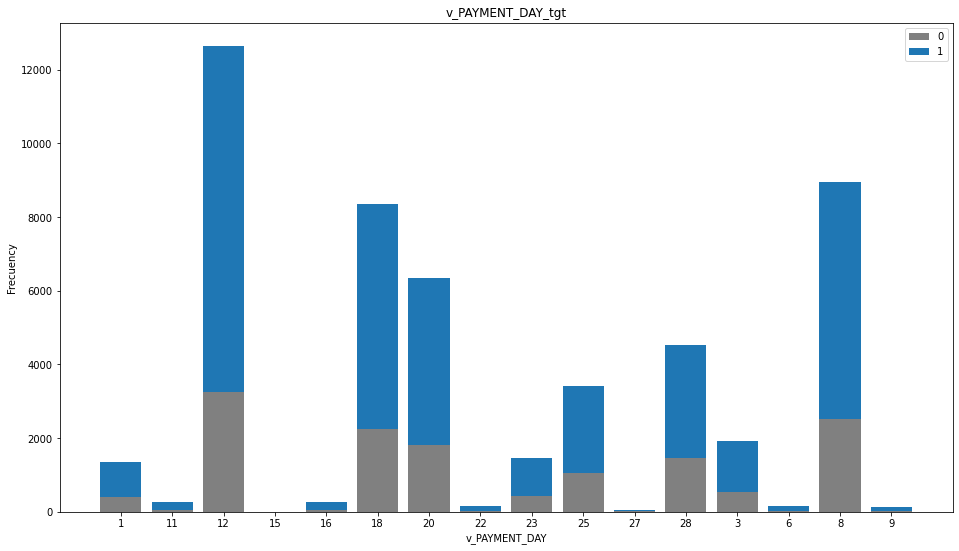

In [ ]:
cross_grafica(df,"v_PAYMENT_DAY", "tgt")

#El día de mayor paga es el 12, proximamente el 8, 18 y 20. siendo estos el 70% de nuestra información
#Mostrando así que el de mayor incumplimiento es el 8, de estos 4 más importantes.

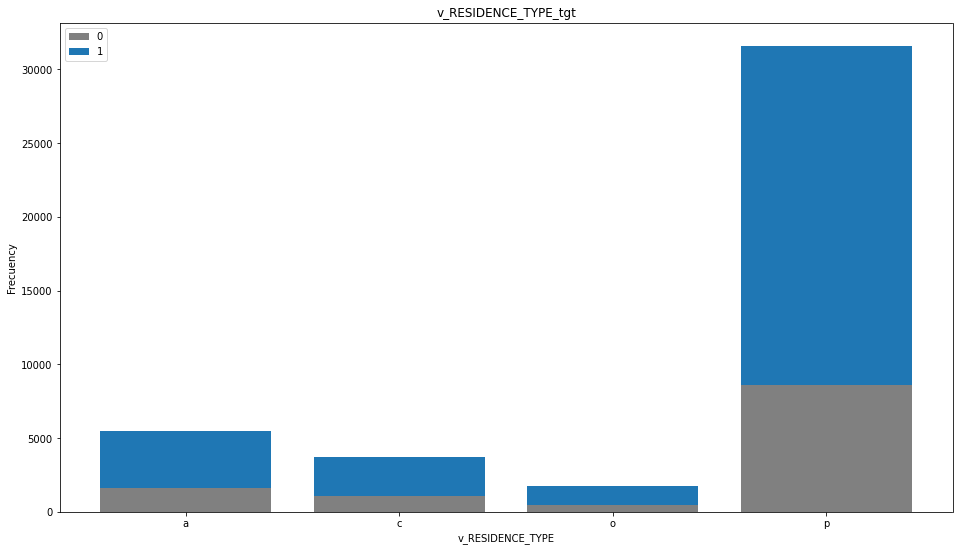

In [ ]:
cross_grafica(df,"v_RESIDENCE_TYPE", "tgt")

#Notemos que la mayoria de nuestros datos se encuentran en el tipo de residencia "p"

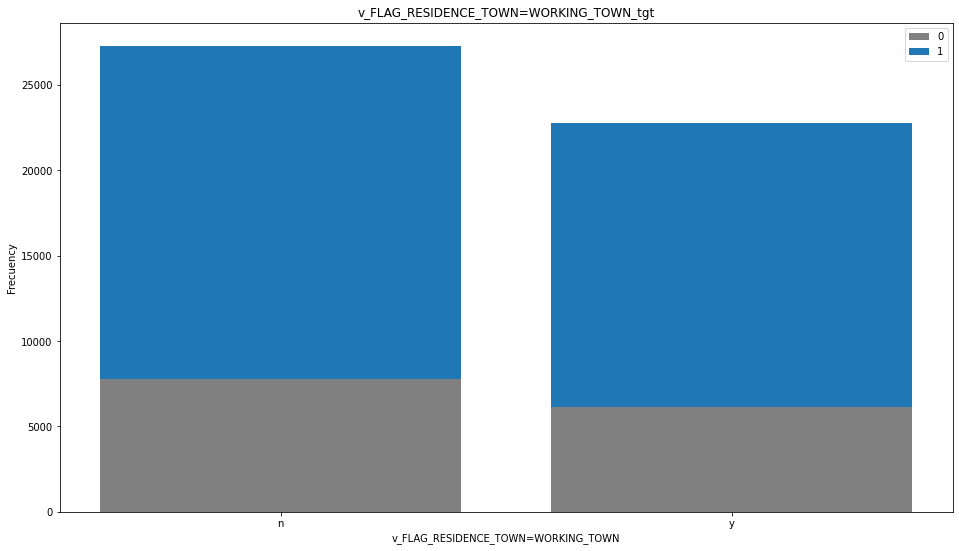

In [ ]:
cross_grafica(df,"v_FLAG_RESIDENCE_TOWN=WORKING_TOWN", "tgt")

#Notemos que esta variable no nos dice mucho, pues a pesar de que es proporcional la porbabilidad 
# de incumplimiento, son casi 45% y 55%, sin embargo muchos no trabajan en ciudad y no viven en la ciudad.

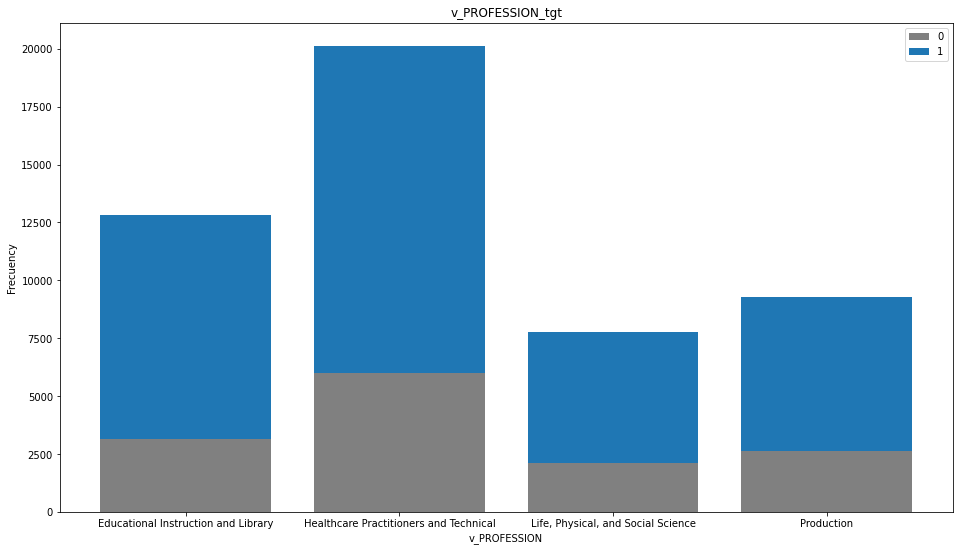

In [ ]:
cross_grafica(df,"v_PROFESSION", "tgt")

#Notemos que la mayoria de nuestros prestatarios son practicantes y tecnicos de la salud, además la mayoria de nuestras variables rondan una probabilidad del 30%

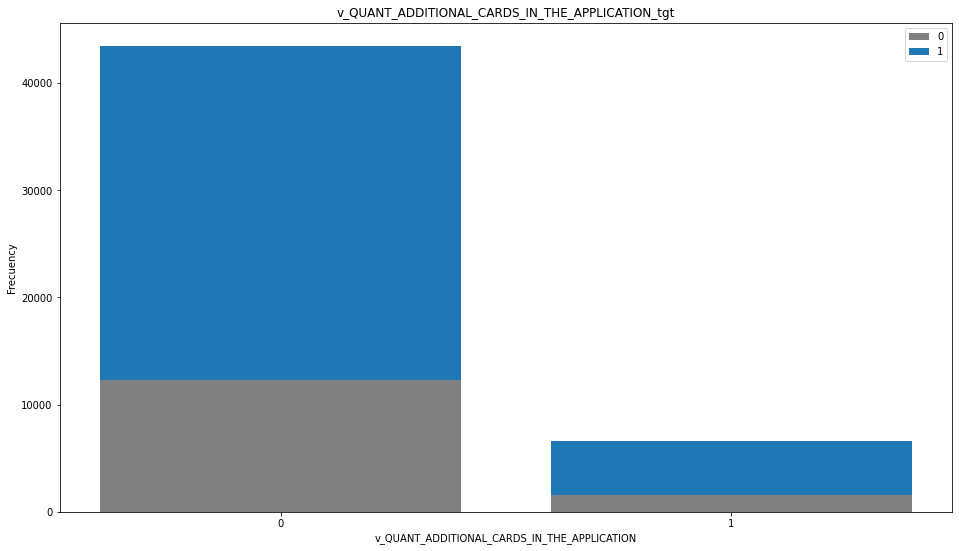

In [ ]:
cross_grafica(df,"v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION", "tgt")

# Notemos que tenemos el 88% aproximadamente de los datos que no tienen tarjetas de credito adicionales
# Los que tienen mayor probabilidad de impago son los que tienen 1 o más tarjetas, maximo 3.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f995001d0>,
      dtype=object)

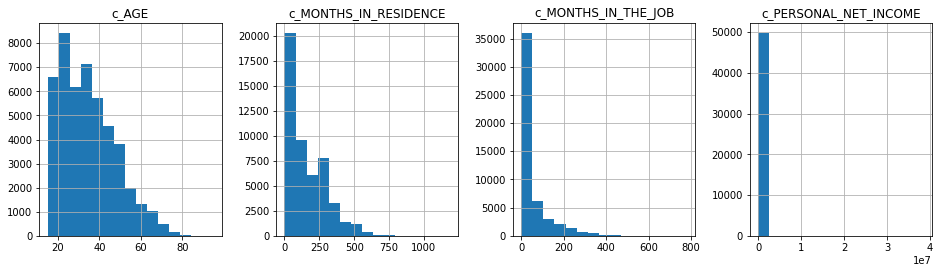

In [ ]:
df[c_variables_new].hist(bins=15, figsize=(16, 9), layout=(2, 4))

#Graficamos las variables numericas y notamos que tenemos muchos outliers

In [ ]:
v_=v_variables_new
v_.remove("v_ID_SHOP")
v_.remove("v_AREA_CODE_RESIDENCIAL_PHONE")

#Tratamiento 1

## Outliers

In [ ]:
tratamiento_1 = df.copy()

In [ ]:
df_multi=df.drop(columns=["v_ID_CLIENT"]).copy()

In [ ]:
#Aplicaremos lof, para mejorar nuestros datos

In [ ]:
df_lof=df_multi.filter(like="c_").dropna()
#parametros del modelo
#contamination :La cantidad de contaminación del conjunto de datos, es decir, la proporción
#de valores atípicos en el conjunto de datos. Al ajustar esto se utiliza para definir el
#umbral en las puntuaciones de las muestras.
model = LocalOutlierFactor(n_neighbors= 6, metric = "euclidean", contamination = 0.02)
y_pred = model.fit_predict(df_lof)

In [ ]:
df_lof["outlier"]=y_pred

In [ ]:
df_lof["outlier"].value_counts(1) #Observamos el porcentaje aproximado que eliminaremos

 1    0.979983
-1    0.020017
Name: outlier, dtype: float64

In [ ]:
outlier_index = np.where(y_pred <=-1) # los valores negativos son valores atípicos
outlier_values = df_lof.iloc[outlier_index]

In [ ]:
df=df_multi.iloc[[x for x in df.index if x not in list(outlier_index[0])]]

In [ ]:
print("Porcentaje sin outliers:", df.shape[0]/50000, "\n")

Porcentaje sin outliers: 0.98106 



## Missings

In [ ]:
#Generamos el dataset de train y test
X_test,X_train=train_test_split(df,train_size=70,stratify=df[["tgt"]],random_state=412)

In [ ]:
#Revisamos los missings y vemos que columnas tendremos mayores a 100

completitud(df)

,columna,total,completitud
0,v_RESIDENCE_TYPE,7334,85.048825
1,c_AGE,2459,94.987055
2,v_SEX,784,98.401729
3,c_PERSONAL_NET_INCOME,194,99.604509
4,c_MONTHS_IN_THE_JOB,3,99.993884
5,v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION,0,100.000000
6,v_FLAG_RESIDENCE_TOWN=WORKING_TOWN,0,100.000000
7,c_MONTHS_IN_RESIDENCE,0,100.000000
8,v_PAYMENT_DAY,0,100.000000
9,v_AREA_CODE_RESIDENCIAL_PHONE,0,100.000000


In [ ]:
#Imputamos los datos de las variables categoricas mediante la moda

print(X_train['v_RESIDENCE_TYPE'].mode()[0])
print(X_train['v_SEX'].mode()[0])
df['v_RESIDENCE_TYPE']=imput_moda('v_RESIDENCE_TYPE')
df['v_SEX']=imput_moda('v_SEX') #Aunque se rechace, debemos imputar los nan para que el modelo pueda llevarse acabo

p
f
Rechazamos HO(La porporción de categorias es la misma que la general)
Rechazamos HO(La porporción de categorias es la misma que la general)


In [ ]:
X_train['v_RESIDENCE_TYPE']=X_train['v_RESIDENCE_TYPE'].replace(np.nan, 'p')
X_test['v_RESIDENCE_TYPE']=X_test['v_RESIDENCE_TYPE'].replace(np.nan,'p')
X_train['v_SEX']=X_train['v_SEX'].replace(np.nan, 'f')
X_test['v_SEX']=X_test['v_SEX'].replace(np.nan,'f')

In [ ]:
#Para las variables numericas imputaremos por la media

In [ ]:
#Edad

mean=X_train["c_AGE"].mean()
median=X_train["c_AGE"].median()
mode=X_train["c_AGE"].mode()[0]   

originales_mean=list(df["c_AGE"].dropna().values)
imputados_mean=list(df["c_AGE"].fillna(mean).values)
s_1=stats.ks_2samp(originales_mean,imputados_mean)

statistic_1=s_1[0]
pvalue_1=s_1[1]

originales_median=list(df["c_AGE"].dropna().values)
imputados_median=list(df["c_AGE"].fillna(median).values)
s_2=stats.ks_2samp(originales_median,imputados_median)
statistic_2=s_2[0]
pvalue_2=s_2[1]
   
originales_mode=list(df["c_AGE"].dropna().values)
imputados_mode=list(df["c_AGE"].fillna(mode).values)
s_3=stats.ks_2samp(originales_mode,imputados_mode)
statistic_3=s_3[0]
pvalue_3=s_3[1]

In [ ]:
## metodo| p-value | estadistico
# initialize list of lists
datos = [['mean', pvalue_1,statistic_1], ['median', pvalue_2,statistic_2], ['mode', pvalue_3,statistic_3]]
 
# Create the pandas DataFrame
final_tableu = pd.DataFrame(datos, columns = ['Method', 'p-value','statistic'])

final_tableu

,Method,p-value,statistic
0,mean,7.537509e-16,0.027251
1,median,3.779535e-13,0.024751
2,mode,4.159638e-39,0.043155


In [ ]:
df['c_AGE']=df['c_AGE'].replace(np.nan,df['c_AGE'].mean())

how=final_tableu.iloc[final_tableu['p-value'].idxmax()]['Method']

imp=SimpleImputer(missing_values=np.nan,strategy=how)

imp.fit(X_train[["c_AGE"]])

X_train[["c_AGE"]]=imp.transform(X_train[["c_AGE"]])
X_test[["c_AGE"]]=imp.transform(X_test[["c_AGE"]])

In [ ]:
# c_PERSONAL_NET_INCOME

c_imput('c_PERSONAL_NET_INCOME')

median
   Method   p-value  statistic
0    mean  0.840916   0.003937
1  median  0.999978   0.001977
2    mode  0.995996   0.002615


In [ ]:
df["c_PERSONAL_NET_INCOME"]=df["c_PERSONAL_NET_INCOME"].replace(np.nan,df["c_PERSONAL_NET_INCOME"].median())

In [ ]:
c_imput('c_MONTHS_IN_THE_JOB')

mean
   Method  p-value  statistic
0    mean      1.0   0.000044
1  median      1.0   0.000031
2    mode      1.0   0.000031


In [ ]:
df["c_MONTHS_IN_THE_JOB"]=df["c_MONTHS_IN_THE_JOB"].replace(np.nan,df["c_MONTHS_IN_THE_JOB"].mean())

In [ ]:
completitud(X_train)

,columna,total,completitud
0,c_AGE,0,100.0
1,v_SEX,0,100.0
2,c_PERSONAL_NET_INCOME,0,100.0
3,v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION,0,100.0
4,c_MONTHS_IN_THE_JOB,0,100.0
5,v_FLAG_RESIDENCE_TOWN=WORKING_TOWN,0,100.0
6,c_MONTHS_IN_RESIDENCE,0,100.0
7,v_RESIDENCE_TYPE,0,100.0
8,v_PAYMENT_DAY,0,100.0
9,v_AREA_CODE_RESIDENCIAL_PHONE,0,100.0


## Ingenieria de variables

In [ ]:
X_train.head()

,c_AGE,v_SEX,c_PERSONAL_NET_INCOME,v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION,c_MONTHS_IN_THE_JOB,v_FLAG_RESIDENCE_TOWN=WORKING_TOWN,c_MONTHS_IN_RESIDENCE,v_RESIDENCE_TYPE,v_PAYMENT_DAY,v_AREA_CODE_RESIDENCIAL_PHONE,v_FLAG_RESIDENCIAL_PHONE,v_MARITAL_STATUS,v_ID_SHOP,tgt,v_PROFESSION
45972,19.0,f,0.0,0,0.0,n,12.0,p,20,50,n,s,15,0,Healthcare Practitioners and Technical
15586,30.0,m,1622.0,1,48.0,n,60.0,a,23,31,y,s,12,0,"Life, Physical, and Social Science"
33581,38.0,f,300.0,0,12.0,n,360.0,p,8,31,y,s,17,1,Healthcare Practitioners and Technical
1383,26.0,f,360.0,0,12.0,n,60.0,p,28,31,y,s,16,1,Healthcare Practitioners and Technical
8871,24.0,f,201.0,0,12.0,y,24.0,p,18,31,y,s,23,0,Healthcare Practitioners and Technical


In [ ]:
#Generamos mejor los años comparados a meses

X_train["c_YEARS_IN_THE_JOB"] = round(X_train["c_MONTHS_IN_THE_JOB"]/12,0)
X_train["c_YEARS_IN_RESIDENCE"] = round(X_train["c_MONTHS_IN_RESIDENCE"]/12,0)

In [ ]:
df.describe()

,c_AGE,c_PERSONAL_NET_INCOME,c_MONTHS_IN_THE_JOB,c_MONTHS_IN_RESIDENCE,tgt
count,49053.000000,4.905300e+04,49053.000000,49053.000000,49053.000000
mean,34.701764,8.335389e+03,50.534067,153.411290,0.721974
std,12.741905,4.392566e+05,73.579205,136.538645,0.448031
min,15.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,24.000000,2.700000e+02,12.000000,36.000000,0.000000
50%,34.000000,4.040000e+02,24.000000,120.000000,1.000000
75%,42.000000,7.500000e+02,60.000000,240.000000,1.000000
max,95.000000,3.852910e+07,780.000000,1188.000000,1.000000


#Reducción de variables

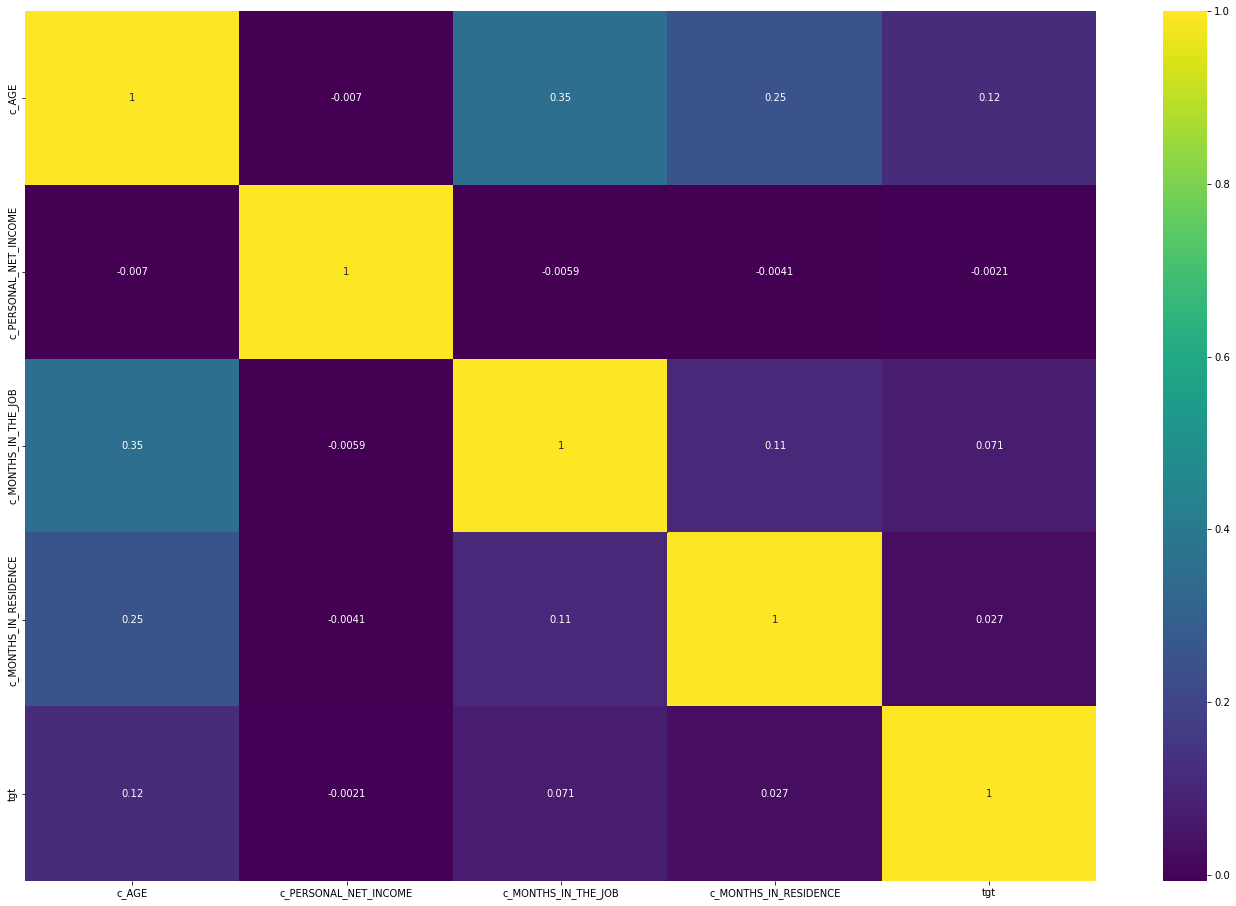

In [ ]:
### GRAFICAS ###

plt.figure(figsize=(24, 16))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

In [ ]:
#Eliminamos los años ya que notamos que no aportan nada, y para los meses podemos ser más precisos

X_train = X_train.drop(columns = ["c_YEARS_IN_THE_JOB", "c_YEARS_IN_RESIDENCE"])

## Mutlticolinealidad

## Categoricas

In [ ]:
v_feats=list(df.filter(like="v_").columns)
resultados=multicolinealidad_cate(df=df[v_feats+["tgt"]],y="tgt")

In [ ]:
resultados

,GVIF,Df,GVIF^(1/2Df),VIF
factor,,,,
v_SEX,1.114341,1,1.055624,1.114341
v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION,1.130519,1,1.063259,1.130519
v_FLAG_RESIDENCE_TOWN=WORKING_TOWN,1.128950,1,1.062520,1.128950
v_RESIDENCE_TYPE,1.129802,3,1.020549,1.041520
v_PAYMENT_DAY,1.053515,15,1.001739,1.003482
v_AREA_CODE_RESIDENCIAL_PHONE,5.092358,2,1.502207,2.256625
v_FLAG_RESIDENCIAL_PHONE,1.422228,1,1.192572,1.422228
v_MARITAL_STATUS,1.243264,4,1.027591,1.055944
v_ID_SHOP,5.290882,30,1.028155,1.057104


In [ ]:
#Comprobamos que todo este en orden

v_feats2=list(df.filter(like="v_").columns)
v_feats2.remove("v_ID_SHOP")
v_feats2.remove("v_PAYMENT_DAY")
resultados2=multicolinealidad_cate(df=df[v_feats2+["tgt"]],y="tgt")
resultados2

,GVIF,Df,GVIF^(1/2Df),VIF
factor,,,,
v_SEX,1.092273,1,1.045118,1.092273
v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION,1.105586,1,1.051469,1.105586
v_FLAG_RESIDENCE_TOWN=WORKING_TOWN,1.048975,1,1.024195,1.048975
v_RESIDENCE_TYPE,1.074765,3,1.012090,1.024325
v_AREA_CODE_RESIDENCIAL_PHONE,1.344358,2,1.076784,1.159464
v_FLAG_RESIDENCIAL_PHONE,1.347702,1,1.160906,1.347702
v_MARITAL_STATUS,1.198314,4,1.022872,1.046267
v_PROFESSION,1.099015,3,1.015860,1.031972


In [ ]:
#Eliminamos las variables que son colineales para así reducirlo

X_train=X_train.drop(columns=["v_PAYMENT_DAY","v_ID_SHOP"]) 
X_test=X_test.drop(columns=["v_PAYMENT_DAY","v_ID_SHOP"]) 

## Análisis de componentes principales

In [ ]:
X_train_c = X_train.filter(like = 'c_')
scaler = StandardScaler()
scaler.fit(X_train_c)
X_sc = scaler.transform(X_train_c)

pca = PCA(n_components=3)
dimention_3 = pca.fit_transform(X_sc)

In [ ]:
# # #Geramos las gráficas
# total_var = pca.explained_variance_ratio_.sum() * 100
# configure_plotly_browser_state()
# fig = px.scatter_3d(
#     dimention_3, x=0, y=1, z=2, color = y_train['tgt'].astype(str),
#     title=f'Total de Varianza Explicada: {total_var:.2f}%',
#     labels={'0': 'CP 1', '1': 'CP 2', '2': 'CP 3'}
# )
# fig.show()

#No me genero la grafica, proximamente sabre porque

# Tratamiento 2

In [ ]:
tratamiento_2 = df.copy() # Tabla limpia

In [ ]:

pd.DataFrame(round(tratamiento_2.var(), 2), columns = ['Varianza'])

,Varianza
c_AGE,1.623600e+02
c_PERSONAL_NET_INCOME,1.929463e+11
c_MONTHS_IN_THE_JOB,5.413900e+03
c_MONTHS_IN_RESIDENCE,1.864280e+04
tgt,2.000000e-01


In [ ]:
pd.DataFrame(round(tratamiento_2.var(), 2), columns = ['Varianza'])

,Varianza
c_AGE,1.623600e+02
c_PERSONAL_NET_INCOME,1.929463e+11
c_MONTHS_IN_THE_JOB,5.413900e+03
c_MONTHS_IN_RESIDENCE,1.864280e+04
tgt,2.000000e-01


In [ ]:
X = tratamiento_2
y = tratamiento_2[["tgt"]]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 12, test_size = .3)

In [ ]:
cols = list(X_train.drop(columns=['tgt', 'v_AREA_CODE_RESIDENCIAL_PHONE', 'c_PERSONAL_NET_INCOME']).columns)

In [ ]:
r_train, r_test, dic, iv = T_E(X_train, X_test, cols)

In [ ]:
pd.concat([r_train.filter(like = 'W_'), r_train['tgt']], axis = 1)

,"(W_AGE, )","(W_SEX, )","(W_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION, )","(W_MONTHS_IN_THE_JOB, )","(W_FLAG_RESIDENCE_TOWN=WORKING_TOWN, )","(W_MONTHS_IN_RESIDENCE, )","(W_RESIDENCE_TYPE, )","(W_PAYMENT_DAY, )","(W_FLAG_RESIDENCIAL_PHONE, )","(W_MARITAL_STATUS, )","(W_ID_SHOP, )","(W_PROFESSION, )",tgt
0,0.349719,0.080076,-0.028514,0.120988,-0.041664,-0.008306,0.023167,-0.202347,0.088029,0.226492,0.180328,-0.103100,1
1,0.349719,0.080076,-0.028514,-0.001009,-0.041664,-0.008306,0.023167,0.116085,0.088029,-0.174491,0.086351,0.170914,1
2,0.349719,0.080076,-0.028514,-0.001009,-0.041664,-0.008306,0.023167,0.053304,0.088029,0.226492,-0.042529,-0.103100,1
3,0.349719,0.080076,-0.028514,-0.001009,-0.041664,-0.008306,0.023167,0.116085,0.088029,0.226492,0.158622,0.013961,1
4,-0.117221,0.080076,-0.028514,-0.001009,-0.041664,-0.008306,0.023167,-0.050061,0.088029,-0.174491,-0.034677,-0.103100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34332,0.349719,0.080076,0.196907,-0.001009,-0.041664,-0.008306,0.023167,-0.000967,0.088029,0.226492,-0.034677,0.170914,1
34333,-0.117221,0.080076,-0.028514,-0.001009,-0.041664,-0.008306,0.044670,-0.050061,0.088029,-0.174491,-0.027727,-0.103100,0
34334,-0.117221,0.080076,-0.028514,-0.001009,-0.041664,-0.008306,-0.114362,0.053304,0.088029,-0.174491,-0.027727,-0.103100,1
34335,-0.117221,-0.175706,-0.028514,-0.001009,0.051609,-0.008306,0.044670,-0.202347,0.088029,-0.174491,0.112456,-0.103100,1


In [ ]:
r_train

,c_AGE,v_SEX,c_PERSONAL_NET_INCOME,v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION,c_MONTHS_IN_THE_JOB,v_FLAG_RESIDENCE_TOWN=WORKING_TOWN,c_MONTHS_IN_RESIDENCE,v_RESIDENCE_TYPE,v_PAYMENT_DAY,v_AREA_CODE_RESIDENCIAL_PHONE,v_FLAG_RESIDENCIAL_PHONE,v_MARITAL_STATUS,v_ID_SHOP,tgt,v_PROFESSION,v_AGE,v_MONTHS_IN_THE_JOB,v_MONTHS_IN_RESIDENCE,"(W_AGE, )","(W_SEX, )","(W_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION, )","(W_MONTHS_IN_THE_JOB, )","(W_FLAG_RESIDENCE_TOWN=WORKING_TOWN, )","(W_MONTHS_IN_RESIDENCE, )","(W_RESIDENCE_TYPE, )","(W_PAYMENT_DAY, )","(W_FLAG_RESIDENCIAL_PHONE, )","(W_MARITAL_STATUS, )","(W_ID_SHOP, )","(W_PROFESSION, )"
0,53.0,f,1500.0,0,480.0,n,36.0,p,28,other,y,c,6,1,Healthcare Practitioners and Technical,"(41.667, 68.333]","(354.0, 708.0]","(-0.888, 444.0]",0.349719,0.080076,-0.028514,0.120988,-0.041664,-0.008306,0.023167,-0.202347,0.088029,0.226492,0.180328,-0.103100
1,45.0,f,28380.0,0,12.0,n,240.0,p,12,50,y,s,55,1,Educational Instruction and Library,"(41.667, 68.333]","(-0.708, 354.0]","(-0.888, 444.0]",0.349719,0.080076,-0.028514,-0.001009,-0.041664,-0.008306,0.023167,0.116085,0.088029,-0.174491,0.086351,0.170914
2,45.0,f,300.0,0,0.0,n,300.0,p,18,31,y,c,10,1,Healthcare Practitioners and Technical,"(41.667, 68.333]","(-0.708, 354.0]","(-0.888, 444.0]",0.349719,0.080076,-0.028514,-0.001009,-0.041664,-0.008306,0.023167,0.053304,0.088029,0.226492,-0.042529,-0.103100
3,53.0,f,900.0,0,48.0,n,240.0,p,12,31,y,c,25,1,"Life, Physical, and Social Science","(41.667, 68.333]","(-0.708, 354.0]","(-0.888, 444.0]",0.349719,0.080076,-0.028514,-0.001009,-0.041664,-0.008306,0.023167,0.116085,0.088029,0.226492,0.158622,0.013961
4,20.0,f,180.0,0,36.0,n,240.0,p,20,31,y,s,24,1,Healthcare Practitioners and Technical,"(14.92, 41.667]","(-0.708, 354.0]","(-0.888, 444.0]",-0.117221,0.080076,-0.028514,-0.001009,-0.041664,-0.008306,0.023167,-0.050061,0.088029,-0.174491,-0.034677,-0.103100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34332,48.0,f,5396.0,1,48.0,n,216.0,p,8,31,y,c,24,1,Educational Instruction and Library,"(41.667, 68.333]","(-0.708, 354.0]","(-0.888, 444.0]",0.349719,0.080076,0.196907,-0.001009,-0.041664,-0.008306,0.023167,-0.000967,0.088029,0.226492,-0.034677,0.170914
34333,22.0,f,360.0,0,12.0,n,48.0,o,20,other,y,s,1,0,Healthcare Practitioners and Technical,"(14.92, 41.667]","(-0.708, 354.0]","(-0.888, 444.0]",-0.117221,0.080076,-0.028514,-0.001009,-0.041664,-0.008306,0.044670,-0.050061,0.088029,-0.174491,-0.027727,-0.103100
34334,22.0,f,196.0,0,12.0,n,204.0,c,18,31,y,s,1,1,Healthcare Practitioners and Technical,"(14.92, 41.667]","(-0.708, 354.0]","(-0.888, 444.0]",-0.117221,0.080076,-0.028514,-0.001009,-0.041664,-0.008306,-0.114362,0.053304,0.088029,-0.174491,-0.027727,-0.103100
34335,19.0,m,291.0,0,12.0,y,12.0,o,28,31,y,s,20,1,Healthcare Practitioners and Technical,"(14.92, 41.667]","(-0.708, 354.0]","(-0.888, 444.0]",-0.117221,-0.175706,-0.028514,-0.001009,0.051609,-0.008306,0.044670,-0.202347,0.088029,-0.174491,0.112456,-0.103100


In [ ]:
iv[iv['IV'] <0.02]

,Variables,IV
1,v_SEX,0.01405
2,v_QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION,0.00561
3,v_MONTHS_IN_THE_JOB,0.00012
4,v_FLAG_RESIDENCE_TOWN=WORKING_TOWN,0.00215
5,v_MONTHS_IN_RESIDENCE,0.00181
6,v_RESIDENCE_TYPE,0.00253
11,v_PROFESSION,0.01165


In [ ]:
iv[(iv['IV'] >= 0.02) & (iv['IV'] < 0.1)]

,Variables,IV
0,v_AGE,0.04194
8,v_FLAG_RESIDENCIAL_PHONE,0.03094
9,v_MARITAL_STATUS,0.04140
